# Bird Classification using ResNet34

## Importing the Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

BASE_DIR = "./data/"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


Setting seed for reproducibility

In [2]:
seed = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(seed)

## Loading the Dataset

The dataset is taken from [Kaggle](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) and consists of 70,658 training, 2250 test and 2259 validation images of birds belonging to 450 different species. The images are of size 224x224x3(HxWxC). The `birds.csv` files consists of the class ID, file paths, labels, scientific label and the dataset[train, test, val] to which the image belongs to. The images are read using python `PIL` library and transforms are applied.

In [3]:
paths_df = pd.read_csv(os.path.join(BASE_DIR, "birds.csv"))
# paths_df.drop(46620, axis= 0, inplace=True) # The dataset as of 9-Jan-2023 contains a file that is 
# present at the given index whose dimension is not 224x224. Removing the file to avoid unnecessary complexity in the code
labels = paths_df["class id"].unique()
bird_name_map = {int(i): paths_df[paths_df["class id"] == i]["labels"].values[0] for i in labels}

In [4]:
paths_df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [5]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89885 entries, 0 to 89884
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class id         89885 non-null  float64
 1   filepaths        89885 non-null  object 
 2   labels           89885 non-null  object 
 3   data set         89885 non-null  object 
 4   scientific name  89885 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.4+ MB


<BarContainer object of 3 artists>

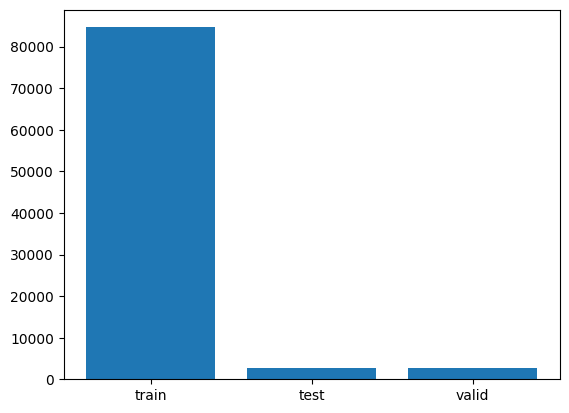

In [6]:
dataset_split = paths_df["data set"].value_counts()
plt.bar(dataset_split.index, dataset_split.values)

In [7]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepaths']
        img_path = os.path.join(BASE_DIR, img_path)
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = self.df.iloc[idx]['class id']
        
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [8]:
normalise_means = [0.4914, 0.4822, 0.4465]
normalise_stds = [0.2023, 0.1994, 0.2010]

train_transform = T.Compose([T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(normalise_means, normalise_stds),])

test_transforms = T.Compose([T.ToTensor(), T.Normalize(normalise_means, normalise_stds)])
    
train_df = paths_df[paths_df['data set'] == 'train']
test_df = paths_df[paths_df['data set'] == 'test']
val_df = paths_df[paths_df['data set'] == 'valid']

train_dataset = BirdDataset(train_df, train_transform)
test_dataset = BirdDataset(test_df, test_transforms)
val_dataset = BirdDataset(val_df, test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

In [9]:
def denormalize(img):
    means = torch.tensor(normalise_means).view(3, 1, 1)
    stds = torch.tensor(normalise_stds).view(3, 1, 1)
    return img * stds + means

def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            image = denormalize(images[i*4 + j]).permute(1, 2, 0)
            label = labels[i*4 + j].item()
            ax[i][j].imshow((image.numpy() * 255).astype(np.uint8))
            title = class_map[label]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, bird_name_map)

## Defining the Model

The project uses a ResNet34 model that is implemented according to the [paper](https://arxiv.org/abs/1512.03385). The only difference is that the model implemented here uses log softmax instead of softmax in the output layer as log softmax gives better accuracy and faster convergence rate.  

In [9]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride= 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride= stride, padding= 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride= 1, padding= 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace= True)

        self.downsample = nn.Sequential()
        
        if stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.downsample(x)

        out = self.relu(out)

        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 7, stride= 2, padding= 3),
            nn.BatchNorm2d(64), nn.MaxPool2d(3, stride= 2, padding= 1), nn.ReLU(inplace= True))

        self.layer0 = self._make_layer(64, 64, 3, 1)
        self.layer1 = self._make_layer(64, 128, 4, 2)
        self.layer2 = self._make_layer(128, 256, 6, 2)
        self.layer3 = self._make_layer(256, 512, 3, 2)

        self.avg_pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))

        for i in range(num_blocks - 1):
            layers.append(BasicBlock(out_channels, out_channels, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        
        out = self.layer0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [10]:
model = ResNet34(450).to(device)
print(model)

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (layer0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, 

## Training 

In [ ]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, valloader):

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
        
    for i in tqdm(range(epochs)):
        running_loss = 0.0
        running_correct = 0
        total = 0

        for images, targets in trainloader:
            
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)
        
        scheduler.step()

        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in valloader:
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            val_acc.append(acc)
            val_losses.append(running_val_loss / len(valloader))

        print(f"Epoch: {i+1}, Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_acc[-1]:.3f}")

    return train_losses, train_acc, val_losses, val_acc

In [ ]:
epochs = 150

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

train_losses, train_acc, val_losses, val_acc = train(model, epochs, optimizer, criterion, scheduler, device, train_loader, val_loader)
print("  Finished Training  ")

In [ ]:
def plot_graphs(train_losses, train_acc, val_losses, val_acc):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Test Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Test Accuracy")
    plt.legend()
    plt.show()

plot_graphs(train_losses, train_acc, val_losses, val_acc)

## Testing

In [ ]:
def test(model, testloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in testloader:
            images, targets = images.to(device), targets.to(device)
            output = model(images)
            preds = torch.argmax(output, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    print(f"Test Accuracy: {correct / total:.3f}")

test(model, test_loader, device)

In [ ]:
def show_test_batch(images, preds, targets, class_map):
    images = denormalize(images.cpu())
    images = images.numpy()
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()

    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(np.transpose(images[i*4+j], (1, 2, 0)))
            ax[i, j].set_title(f"Actual: {class_map[targets[i*4+j]]}\nPred: {class_map[preds[i*4+j]]}")
            ax[i, j].axis("off")

images, targets = next(iter(test_loader))
images, targets = images.to(device), targets.to(device)
output = model(images)
preds = torch.argmax(output, dim=1)

show_test_batch(images, preds, targets, bird_name_map)

## Saving the Model

In [ ]:
torch.save(model.state_dict(), 'birds_resnet34_model.pth')

In [ ]:
from IPython.display import FileLink
FileLink('birds_resnet34_model.pth')

In [ ]:
import json

json.dump( bird_name_map, open( "birds_name_mapping.json", 'w' ) )
FileLink('birds_name_mapping.json')